##El problema de clasificación a resolver es la identificación de personas sonriendo o no. Para hacerlo, creamos y entrenamos un CNN model. Este es mayormente utilizado para clasificacion de imagenes (para reconocer objetos, caras, etc). (...)


##Dataset: https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data?select=test

In [1]:
!pip3 install keras-visualizer #instala el paquete de keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Instala todas las librerias necesarias

In [2]:
import numpy as np


In [10]:
from keras_visualizer import visualizer 
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image
from keras.applications.resnet import preprocess_input

##Conexion con Google Drive 

In [5]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from google.colab import files
from google.colab import auth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
 
from IPython.display import Image
import cv2
import zipfile
 
import os

##Acceso a una cuenta de Google y al archivo seleccionado

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
file_ID = "1_OorW0B3rLsTbWlIoOO_bwcoX7k76zA-"
download = drive.CreateFile({'id': file_ID})
download.GetContentFile('datasetSmileOrNot.zip')
 
!unzip /content/datasetSmileOrNot.zip

Archive:  /content/datasetSmileOrNot.zip
   creating: datasetSmileOrNot/
  inflating: __MACOSX/._datasetSmileOrNot  
  inflating: datasetSmileOrNot/.DS_Store  
  inflating: __MACOSX/datasetSmileOrNot/._.DS_Store  
   creating: datasetSmileOrNot/non_smile/
  inflating: __MACOSX/datasetSmileOrNot/._non_smile  
   creating: datasetSmileOrNot/smile/
  inflating: __MACOSX/datasetSmileOrNot/._smile  
  inflating: datasetSmileOrNot/non_smile/Gerry_Kelly_0001.jpg  
  inflating: __MACOSX/datasetSmileOrNot/non_smile/._Gerry_Kelly_0001.jpg  
  inflating: datasetSmileOrNot/non_smile/Arnold_Schwarzenegger_0025.jpg  
  inflating: __MACOSX/datasetSmileOrNot/non_smile/._Arnold_Schwarzenegger_0025.jpg  
  inflating: datasetSmileOrNot/non_smile/Donald_Rumsfeld_0015.jpg  
  inflating: __MACOSX/datasetSmileOrNot/non_smile/._Donald_Rumsfeld_0015.jpg  
  inflating: datasetSmileOrNot/non_smile/Andy_Wisecarver_0001.jpg  
  inflating: __MACOSX/datasetSmileOrNot/non_smile/._Andy_Wisecarver_0001.jpg  
  inflatin

##Asigna el images path de cada clase 

In [7]:
print(os.listdir('/content/datasetSmileOrNot'))

smile_train_path = '/content/datasetSmileOrNot/smile'
non_train_path = '/content/datasetSmileOrNot/non_smile'

read = lambda image_name: np.asarray(Image.open(image_name).convert("RGB"))

['non_smile', 'smile', '.DS_Store']


##Carga el dataset

In [8]:
def loadDataset():
    ## Load training images 
    smile_images = [read(os.path.join(smile_train_path, filename)) for filename in os.listdir(smile_train_path)]
    X_smile_train = np.array(smile_images, dtype='uint8')
    non_images = [read(os.path.join(non_train_path, filename)) for filename in os.listdir(non_train_path)]
    X_non_train = np.array(non_images, dtype='uint8')
    
    ## Generate labels
    Y_smile_train = np.zeros((X_smile_train.shape[0],1))
    Y_non_train = np.ones((X_non_train.shape[0],1))
   
    ## Merge Data
    X_train = np.concatenate((X_smile_train, X_non_train), axis = 0)
    Y_train = np.concatenate((Y_smile_train, Y_non_train), axis = 0)
    
    ## Shuffle data
    arr = np.arange(X_train.shape[0])
    np.random.shuffle(arr)
    X_train = X_train[arr]
    Y_train = Y_train[arr]
    
    return X_train,Y_train

##Imprime la shape de las imagenes y de los labels

In [11]:
X_train,Y_train = loadDataset()

print(X_train.shape)
print(Y_train.shape)

(1203, 64, 64, 3)
(1203, 1)


In [23]:
X_train

array([[[[0.65490196, 0.41176471, 0.31372549],
         [0.68235294, 0.44705882, 0.35294118],
         [0.69803922, 0.47058824, 0.37647059],
         ...,
         [0.0745098 , 0.05098039, 0.05882353],
         [0.05490196, 0.03529412, 0.05882353],
         [0.05490196, 0.04313725, 0.07058824]],

        [[0.66666667, 0.42352941, 0.33333333],
         [0.68627451, 0.45098039, 0.35686275],
         [0.69411765, 0.46666667, 0.37254902],
         ...,
         [0.05490196, 0.03137255, 0.03137255],
         [0.05490196, 0.03529412, 0.05098039],
         [0.07058824, 0.0627451 , 0.08235294]],

        [[0.66666667, 0.43137255, 0.3372549 ],
         [0.67843137, 0.45098039, 0.35686275],
         [0.68627451, 0.46666667, 0.37647059],
         ...,
         [0.03921569, 0.00784314, 0.        ],
         [0.03921569, 0.02352941, 0.02745098],
         [0.06666667, 0.04705882, 0.0627451 ]],

        ...,

        [[0.05098039, 0.04313725, 0.08627451],
         [0.05882353, 0.04705882, 0.08235294]

In [24]:
Y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

##Muestra de algunas imagenes de cada clase

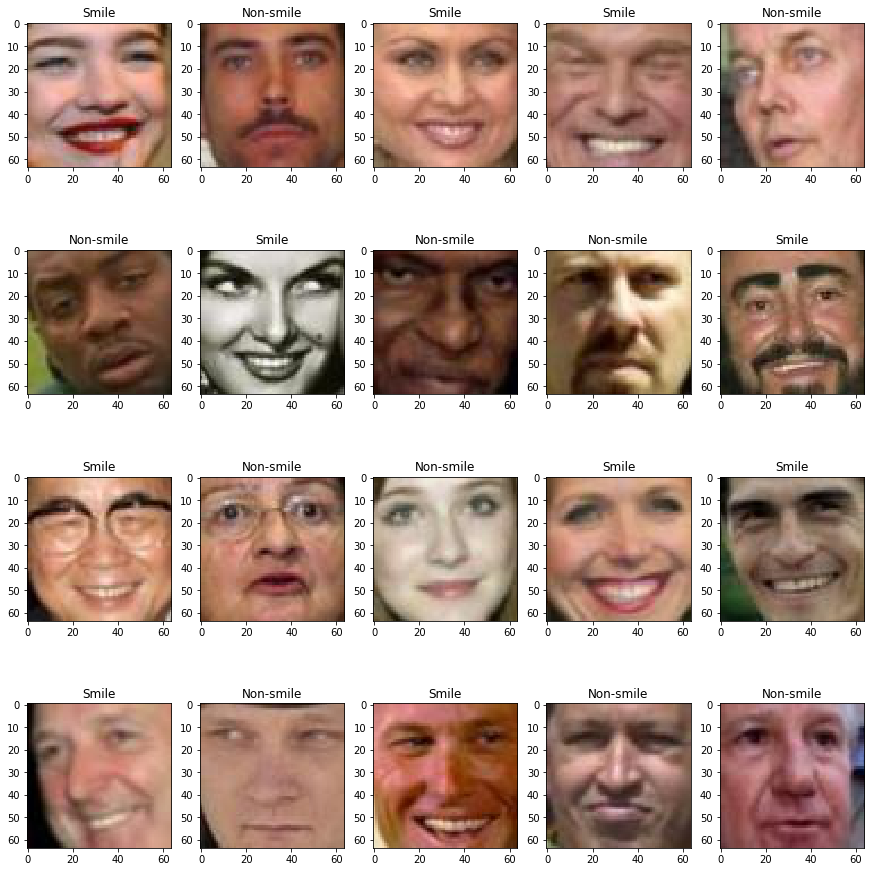

In [12]:
fig=plt.figure(figsize=(15, 16))

for i in range(1, 21): #4*5+1 = 21
    ax = fig.add_subplot(4, 5, i)
    if Y_train[i] == 0:
        ax.title.set_text('Smile')
    else:
        ax.title.set_text('Non-smile')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

##Normaliza los valores de las imagenes

In [13]:
print(Y_train.shape) #imprime la shape de los labels

# Normalize all values of the pictures by dividing all the RGB values by 255
X_train = X_train/255.0

print(X_train.shape) #imprime la nueva shape de las imagenes

(1203, 1)
(1203, 64, 64, 3)


In [14]:
# Turn labels into one hot encoding
Y_train = to_categorical(Y_train, num_classes= 2)

##CNN Model

In [15]:
model = tf.keras.Sequential(name='smiling_or_not_model') #crea un modelo de tipo sequential 
model.add(layers.Conv2D(64, (3, 3), padding="same", activation='relu', input_shape=(64, 64, 3))),
model.add(layers.MaxPool2D((2, 2))),
model.add(layers.Dropout(0.25)), #setea los inputs en 0 mientras se entrena, esto reduce el overfitting (ocurre cuando solo se obtienen buenos resultados con las imagenes del training set)
model.add(layers.Conv2D(128, (3, 3), padding="same", activation='relu', input_shape=(64, 64, 3))),
model.add(layers.MaxPool2D((2, 2))),
model.add(layers.Dropout(0.25)),
model.add(layers.Flatten()), #convierte los elementos de la matriz de imagenes de entrada en un array plano
model.add(layers.Dense(2, activation='sigmoid')), #es la capa de salida, tiene 2 outputs (0-1). se usa sigmoid como funcion de activacion ya que se trata de una image classification de unicamente dos clases. La sigmoid function transforma los valores de entrada a una escala (0,1), donde los valores altos tienden a 1, y los valores muy bajos a 0.


(None,)

In [16]:
model.build()

In [17]:
model.summary()

Model: "smiling_or_not_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 12

In [18]:
model

##Se muestra un grafico del comportamiento del modelo (haciendo uso de keras-visualizer)

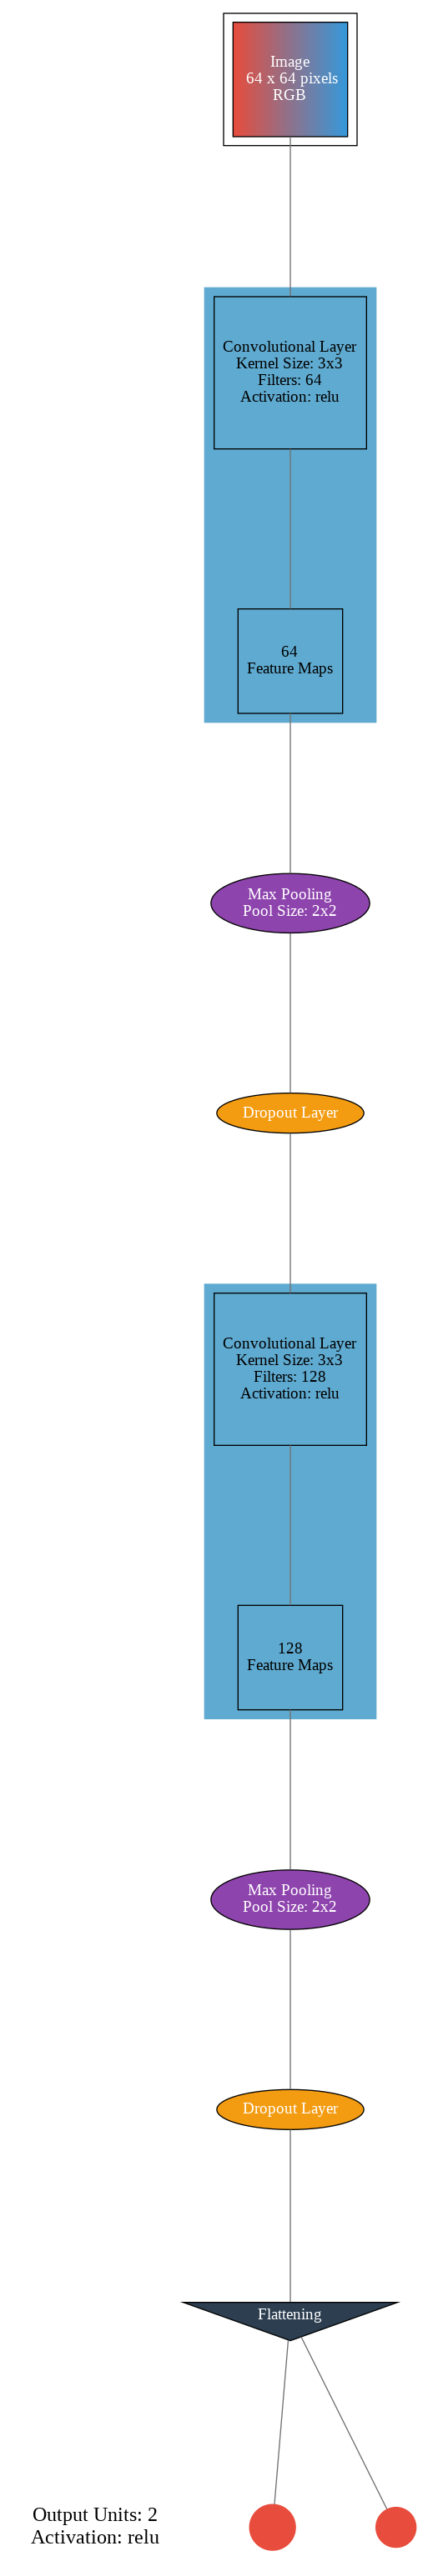

In [19]:
visualizer(model, format='png', view=True)
Image.open("graph.png")

##El ultimo paso antes del entrenamiento del modelo: compilar

In [20]:
model.compile(
    optimizer='adam', #optimizer --> cambia algunos atributos del modelo como, por ejemplo, las weights y el learning rate para reducir el loss y mejorar la accuracy
    loss='binary_crossentropy', #loss --> evalua cuan bien se entrena el modelo, si la prediccion no da bien, la funcion dara un numero muy alto. en cambio, si da bien, dara un numero muy bajo.
    metrics=['accuracy'] #metrics --> las metricas que se tienen en cuenta para evaluar como se entrena el modelo
)

In [25]:
callback_list=[
    callbacks.EarlyStopping(monitor="accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="accuracy",patience=3)
]

#callbacks --> son funciones que se usan mientras el modelo se entrena, sirven para prevenir el overfitting, visualizar el progreso del entrenamiento, etc.
#EarlyStopping --> frena el entrenamiento cuando una metrica (en este caso se basa en accuracy) no mejora con el tiempo
#ReduceLROnPlateau --> reduce la Learning Rate cuando una metrica (en este caso se basa en accuracy) no mejora con el tiempo

##Model training

In [28]:
model.fit(X_train, Y_train, batch_size=64, epochs=50, verbose="auto", callbacks=callback_list, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False
        )
#epochs --> indica la cantidad de pasadas que el modelo se entrena a traves de todo el conjunto de datos de entrenamiento. frena al llegar a 1 (valor maximo para accuracy)
#batch_size --> indica el numero de datos que tiene cada iteracion de un ciclo (epoch)


Epoch 1/50
19/19 [==============================] - 0s 19ms/step - loss: 0.0069 - accuracy: 0.9992 - lr: 4.0960e-04
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0055 - accuracy: 0.9992 - lr: 4.0960e-04
Epoch 3/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0053 - accuracy: 0.9992 - lr: 4.0960e-04
Epoch 4/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0038 - accuracy: 1.0000 - lr: 4.0960e-04
Epoch 5/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0042 - accuracy: 1.0000 - lr: 4.0960e-04
Epoch 6/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0055 - accuracy: 0.9992 - lr: 4.0960e-04
Epoch 7/50
19/19 [==============================] - 0s 16ms/step - loss: 0.0042 - accuracy: 0.9992 - lr: 4.0960e-04
Epoch 8/50
19/19 [==============================] - 0s 17ms/step - loss: 0.0039 - accuracy: 1.0000 - lr: 3.2768e-04
Epoch 9/50
19/19 [==============================] - 0s 16ms/step - loss:

##Se guarda el modelo como un archivo .h5 para luego cargarlo y usarlo para la prediccion

In [30]:
model.save('smileOrNotModel.h5')

In [31]:
new_model = keras.models.load_model('smileOrNotModel.h5')

##Funcion que recibe el path de una imagen, la procesa y la devuelve como un array

In [32]:
def receive_resize_img(ejemploImagen):    
    img = image.load_img(ejemploImagen, target_size=(64,64))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)
    return img_preprocessed

##Ejemplo: se le da una imagen perteneciente a la carpeta de smile

In [33]:
receive_resize_img('/content/datasetSmileOrNot/smile/Jamling_Norgay_0001.jpg')

array([[[[-79.939    , -66.779    , -36.68     ],
         [-62.939003 , -49.779    , -19.68     ],
         [-45.939003 , -32.779    ,   0.3199997],
         ...,
         [-51.939003 , -39.779    ,   3.3199997],
         [-48.939003 , -38.779    ,   2.3199997],
         [-44.939003 , -34.779    ,   4.3199997]],

        [[-77.939    , -64.779    , -34.68     ],
         [-61.939003 , -48.779    , -18.68     ],
         [-46.939003 , -33.779    ,  -0.6800003],
         ...,
         [-47.939003 , -34.779    ,   4.3199997],
         [-45.939003 , -35.779    ,   2.3199997],
         [-44.939003 , -33.779    ,   1.3199997]],

        [[-73.939    , -60.779    , -31.68     ],
         [-59.939003 , -46.779    , -16.68     ],
         [-47.939003 , -33.779    ,  -3.6800003],
         ...,
         [-41.939003 , -28.779    ,   4.3199997],
         [-44.939003 , -31.779    ,  -1.6800003],
         [-43.939003 , -32.779    ,  -3.6800003]],

        ...,

        [[-69.939    , -71.779    , -6

##Funcion que recibe la imagen procesada y devuelve si es una persona sonriendo o no. Si lo es, el primer digito 1 sino, 0.

In [34]:
def predict_img(ejemploImagenProcesada):
  loaded_model = tf.keras.models.load_model('smileOrNotModel.h5') #carga el modelo
  resultado = loaded_model.predict(ejemploImagenProcesada) #realiza la prediccion
  predicted_class = (resultado > 0.5).astype("int32") 

  print("----RESULTADO-----")
  print(resultado)

In [35]:
predict_img(receive_resize_img('/content/datasetSmileOrNot/smile/Margie_Puente_0001.jpg'))

1/1 [==============================] - 0s 128ms/step
----RESULTADO-----
[[1. 0.]]


##Otro ejemplo (en este caso, con una imagen descargada de Google)

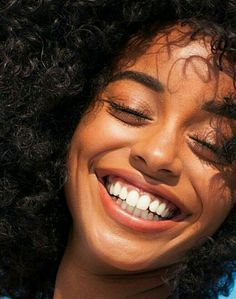

In [40]:
from IPython.display import Image
Image('/sonrisa.jpg')

In [38]:
receive_resize_img('/sonrisa.jpg')

array([[[[ -98.939    , -110.779    , -119.68     ],
         [ -81.939    ,  -93.779    ,  -96.68     ],
         [ -51.939003 ,  -58.779    ,  -58.68     ],
         ...,
         [ -88.939    ,  -96.779    , -104.68     ],
         [ -83.939    ,  -92.779    ,  -98.68     ],
         [ -73.939    ,  -81.779    ,  -85.68     ]],

        [[-101.939    , -105.779    , -115.68     ],
         [ -97.939    , -105.779    , -109.68     ],
         [ -77.939    ,  -90.779    ,  -91.68     ],
         ...,
         [ -88.939    ,  -98.779    , -101.68     ],
         [ -91.939    , -101.779    , -104.68     ],
         [ -72.939    ,  -81.779    ,  -83.68     ]],

        [[ -67.939    ,  -74.779    ,  -82.68     ],
         [ -89.939    ,  -99.779    , -102.68     ],
         [ -94.939    , -108.779    , -113.68     ],
         ...,
         [ -89.939    ,  -97.779    , -106.68     ],
         [ -79.939    ,  -87.779    ,  -95.68     ],
         [ -88.939    ,  -96.779    , -102.68     ]],

In [39]:
predict_img(receive_resize_img('/sonrisa.jpg'))

1/1 [==============================] - 0s 53ms/step
----RESULTADO-----
[[1. 0.]]
